# Euler method
Implementation of the Euler method to solve Jarrah's system (there's no diffusion term as there are no neighbouring cells, it is an ODEs system, there's no dependence on space).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser

### Euler integrator

In [2]:
def euler(t_i, t_max, dt, initial_conditions, parameters, damage_par):

    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D = parameters
    sigma, m, h = damage_par

    num_steps = int((t_max - t_i) / dt)

    H = [0.] * num_steps
    C = [0.] * num_steps
    M = [0.] * num_steps
    N = [0.] * num_steps
    D = [0.] * num_steps
    R = [0.] * num_steps

    H[0] = H_i
    C[0] = C_i
    M[0] = M_i
    N[0] = N_i
    D[0] = D_i
    R[0] = R_i
    
    t = [0.] * num_steps

    for i in range(num_steps - 1):

        H[i+1] = H[i] + dt * (k1 * D[i] * M[i] + d_H * (H[0] - H[i]))
        C[i+1] = C[i] + dt * (k2 * D[i] * H[i] + d_C * (C[0] - C[i]))        
        M[i+1] = M[i] + dt * (k3 * D[i] * M[i] + d_M * (M[0] - M[i]))
        N[i+1] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, i, sigma, m, h)))
        D[i+1] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, i, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
        R[i+1] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

        t[i+1] = dt * i

    return H, C, M, N, D, R, t
    

### Damage function

In [3]:
def damage(t, i, sigma, m, h):

    if t[i]==0 or t[i] <=1e-7:
        return 0.
    else:
        return h / (t[i] * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t[i]) - m)**2 / (2. * sigma**2))

### Function to retrieve information from the configuration file

In [4]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### Simulation

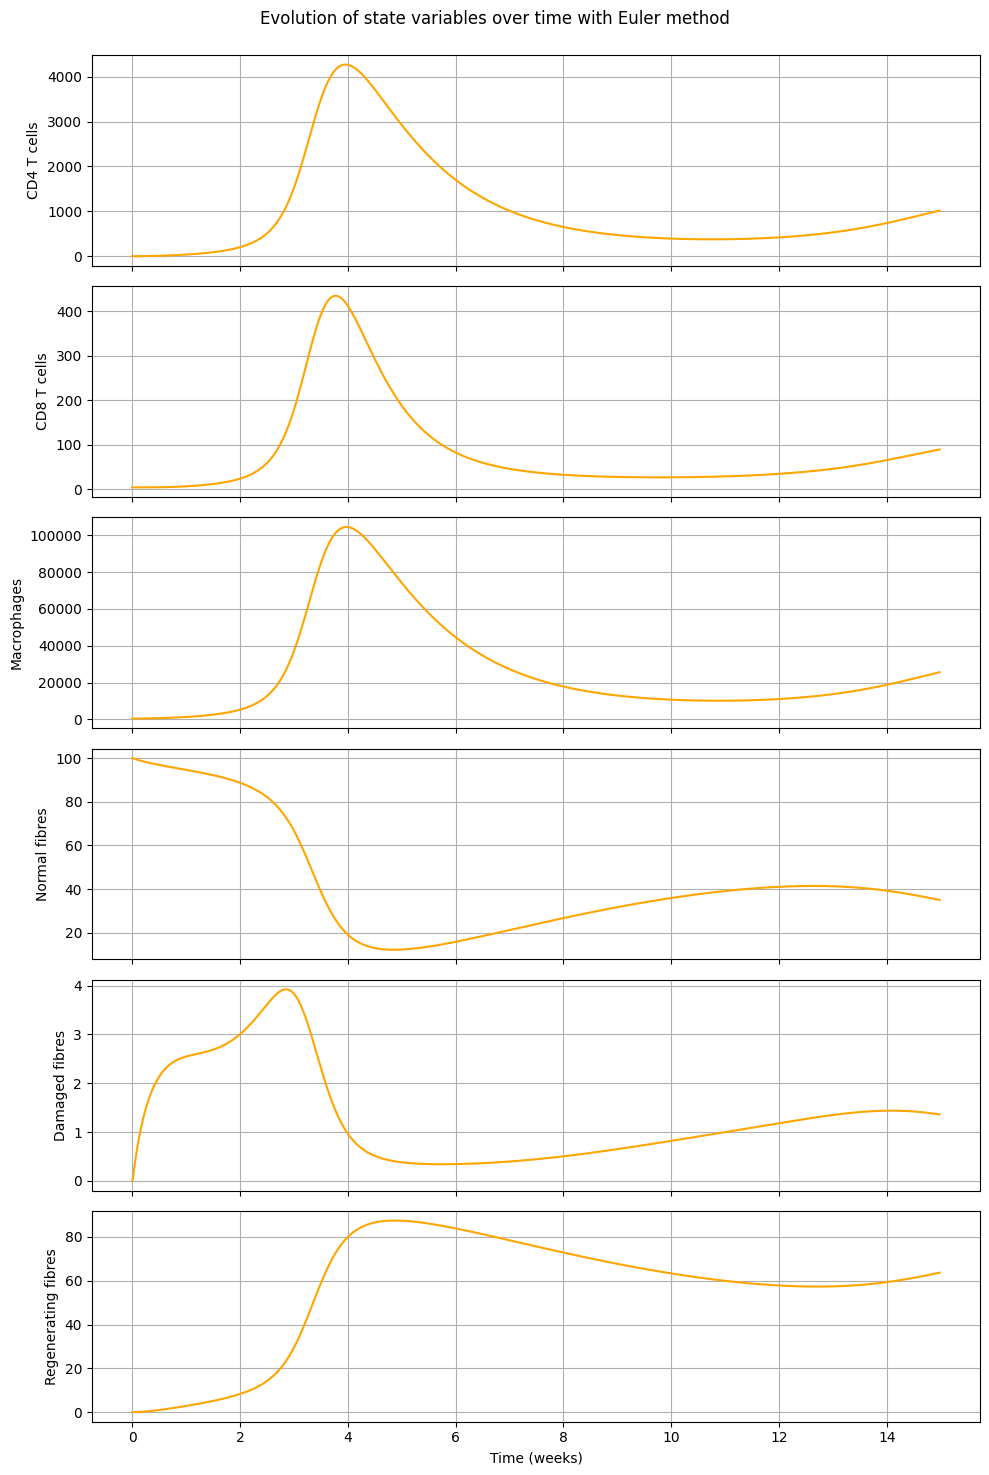

In [5]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config_euler.ini')

initial_conditions = extract_values('initial_conditions', config)
parameters = extract_values('parameters', config)
damage_par = extract_values('damage_parameters', config)
time_par = extract_values('time_par', config)
dt, t_min, t_max = time_par

H, C, M, N, D, R, t = euler(t_min, t_max, dt, initial_conditions, parameters, damage_par)

n_vars = len(initial_conditions)
labels = ["CD4 T cells", "CD8 T cells", "Macrophages", "Normal fibres", "Damaged fibres", "Regenerating fibres"]
state_var = [H, C, M, N, D, R]

#create subplots
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, state_var[i], label=labels[i], color='orange')
    axes[i].set_ylabel(labels[i])
    #axes[i].legend()
    axes[i].grid(True)

#the last subplot is the only one with the label on the x axes
axes[-1].set_xlabel('Time (weeks)')

fig.suptitle('Evolution of state variables over time with Euler method')

#adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig(f"paper_reproduction_euler.png")

plt.show()